# Project : Call Center Operations Optimization

## Theoretical Description


This project aims to simulate and optimize call center operations using principles of queuing theory. It models the behavior of incoming customer calls and agent handling, computes critical performance indicators such as average wait time and system load, and analyzes how varying the number of agents influences overall operational efficiency.


## Problem Context

- Incoming calls are assumed to follow a **Poisson arrival process**, representing random call timings.
- The duration of each call is **exponentially distributed**, reflecting variable service times.
- A queuing simulation is employed to realistically replicate agent availability and response behavior in the system.


In [ ]:
# Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# Parameters
lamb = 20  # Average arrival rate (calls per hour)
mu = 5     # Average service rate per agent (calls per agent per hour)
shift_hours = 8  # Duration of the shift in hours

# Set random seed for reproducibility
np.random.seed(1)

# Simulate inter-arrival times (exponentially distributed)
inter_arrival_times = np.random.exponential(1 / lamb, int(lamb * shift_hours * 1.5))
arrival_times = np.cumsum(inter_arrival_times)
arrival_times = arrival_times[arrival_times < shift_hours]  # Keep calls within 8-hour shift
N = len(arrival_times)  # Total number of calls

# Simulate service times (exponentially distributed)
service_times = np.random.exponential(1 / mu, N)

In [ ]:
# Queue simulation function
def simulate_queue(num_agents):
    next_available = np.zeros(num_agents)  # Tracks when each agent becomes available
    wait_times = np.zeros(N)               # Wait time for each call
    system_sizes = np.zeros(N)             # Number of customers in the system at each arrival
    departure_times = []                   # Service completion times

    for i, arrival in enumerate(arrival_times):
        agent_index = np.argmin(next_available)  # Find the next available agent
        start_time = max(arrival, next_available[agent_index])  # Call starts either at arrival or when agent is free
        wait_times[i] = start_time - arrival
        end_time = start_time + service_times[i]
        next_available[agent_index] = end_time  # Update agent's availability
        departure_times.append(end_time)
        system_sizes[i] = np.sum(np.array(departure_times) > arrival)  # Number still in the system

    return wait_times, system_sizes

In [ ]:
# Run simulation for 5 agents
wait_times, system_sizes = simulate_queue(5)

# Output results
print("Total calls handled:", N)
print("Average wait time: {:.2f} minutes".format(np.mean(wait_times) * 60))  # converted to minutes
print("Average system size: {:.2f}".format(np.mean(system_sizes)))

Total calls handled: 163
Average wait time: 5.05 minutes
Average system size: 6.82


## Compare to M/M/1 Analytic Formula
The M/M/1 queue model is a mathematical framework used to predict the performance of a call center with a single agent. In this model, the first "M" indicates that call arrivals follow a Poisson distribution, meaning they occur randomly over time. The second "M" shows that service times are also random, following an exponential distribution. The "1" refers to having one server or agent handling the calls. This model provides formulas to estimate key performance metrics:

Utilization factor (the proportion of time the agent is busy):
ρ= λ/μ
​

Average number of customers in the system (including those waiting and being served):
L = P/1-P


Average time a customer spends in the system (total time including both waiting and service):
𝑊 = L/λ


These theoretical calculations offer a baseline for evaluating and comparing the actual performance of a simulated call center with one agent.



In [ ]:
p1=lamb/mu
# Define rho as the utilization factor
rho = lamb / mu
l_analytic=rho/(1-rho)
w_analytic=l_analytic/lamb
print("Average wait time:", w_analytic)
print("Average system size:", l_analytic)

Average wait time: -0.06666666666666667
Average system size: -1.3333333333333333


## Test Staffing Levels

In this section, we assess how the number of agents affects customer wait times, aiming to determine the minimum staffing needed so that 95% of customers wait less than 5 minutes.

The simulation is performed for agent counts ranging from 1 to 5. For each scenario, it calculates key performance indicators such as the average wait time, the 95th percentile of wait times, and the average number of customers in the system. These results are then summarized in a comparison table.

The goal is to identify the lowest number of agents that satisfies the wait time requirement. If no configuration meets the criteria, the system concludes that even with 5 agents, the performance target is not achieved.

In [ ]:
threshold=5
results=[]
for s in range(1,6):
  w,q=simulate_queue(s)
  waits_min=w*60
  p95_wait=np.percentile(waits_min,95)
  results.append((s,waits_min.mean(),p95_wait,q.mean()))
df=pd.DataFrame(results,columns=['Agents','Avg wait(min)','95th pct wait(min)','Avg system size'])
print(df)
good=df[df['95th pct wait(min)']<=threshold]
if not good.empty:
  best_s=int(good.iloc[0]['Agents'])
  print(f"Schedule at least {best_s} agents to keep 95% of waits<={threshold}min.")
else:
  print("Even 5 agents can't meet the 5 min ")

   Agents  Avg wait(min)  95th pct wait(min)  Avg system size
0       1     808.232100         1488.275544        65.993865
1       2     284.004529          520.338714        49.042945
2       3     109.126322          191.268183        29.423313
3       4      23.259675           39.865347        11.846626
4       5       5.053611           15.062201         6.815951
Even 5 agents can't meet the 5 min 


## Visualizing Wait Time Distributions
This part of the analysis focuses on illustrating how customer wait times vary with different staffing levels, specifically from 1 to 5 agents.

## Methodology:
The simulate_queue() function is executed for each number of agents.

The resulting wait times are converted from hours to minutes for clarity.

A combined histogram is generated to show the distribution of wait times:

Each staffing level is represented by a different color.

The height of each bar reflects how many customers fell into that wait time range.

## Visualization Highlights:
A dashed vertical line at 5 minutes marks the target wait time threshold.

The x-axis represents wait times in minutes.

The y-axis displays the number of customers in each time interval.

## Objective:
This visual comparison helps demonstrate how adding more agents:

Lowers the frequency of excessive wait times

Improves the overall distribution of service delays

Supports making informed decisions about the most effective staffing level for maintaining service quality


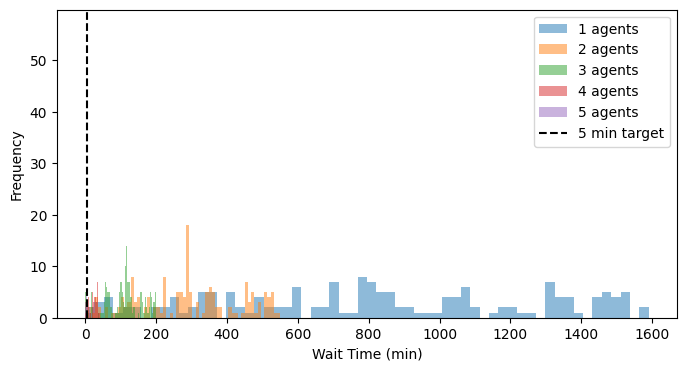

In [ ]:
plt.figure(figsize=(8, 4))
for s in[1,2,3,4,5]:
  w,_=simulate_queue(s)
  plt.hist(w*60,bins=60,alpha=0.5,label=f'{s} agents')
plt.axvline(threshold,color='k',linestyle='--',label='5 min target')
plt.xlabel('Wait Time (min)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## Time-Varying Arrival Rates
This section introduces a more realistic scenario where call volumes change over the course of an 8-hour shift, capturing typical fluctuations between peak and off-peak hours.

### Defined Time Periods:
Time Segments and Arrival Rates:
Morning Rush (0–3 hours):

Calls arrive at 30 per hour

Midday Slowdown (3–5 hours):

Rate drops to 20 calls per hour

Afternoon Surge (5–8 hours):

Call volume increases to 40 per hour

### Process:

For each time segment, inter-arrival times are randomly generated using a Poisson process based on that period's rate.

These times are converted into cumulative arrival times and offset to align with the correct starting hour of each block.

All arrival times are then merged and sorted chronologically.

A fixed team of 5 agents handles the calls throughout the entire shift.

### Output:
The simulation records individual customer wait times.
It then computes and displays the average wait time in minutes across all calls.

### Purpose:
By simulating variable call traffic, this model better reflects real-world call center dynamics. It provides insights into how the system performs under changing workloads and helps assess whether current staffing levels are sufficient during both low and high demand periods.




In [ ]:
#Time-Varying Arrival Rates(Peak vs off-Peak)
#Model lambda changing over the 8 hour shift for example,a morning "rush" ,a midday lull,and an afternoon spike.
# Real call ceneters see non-stationary traffic

def simulate_queue_timevarying(s):
  periods=[(0,2,30),(2,6,20),(6,8,40)]
  arrival=[]
  for start,end,lam in periods:
    duration=end-start
    inter=np.random.exponential(1/lam,int(lam*duration*1.5))
    ts=np.cumsum(inter)+start
    arrival.extend(ts[ts<end])

  arrivals = np.array(arrival)

  arrivals.sort()
  N=len(arrivals)
  service=np.random.exponential(1/mu,N)
  next_free=np.zeros(s)
  wait_times=np.zeros(N)
  for i,t in enumerate(arrivals):
    j=np.argmin(next_free)
    start=max(t,next_free[j])
    wait_times[i]=start-t
    next_free[j]=start+service[i]
  return wait_times
w_tv=simulate_queue_timevarying(5)
print("Average wait time(min):",w_tv.mean()*60)


Average wait time(min): 28.94050166996809


## Customer Abandonment (Patience Threshold)

This simulation models a scenario where **customers hang up** if they wait **longer than 5 minutes**.

- **Arrival and service times** are randomly generated.
- Calls are handled by **5 agents**.
- If a customer's **wait time > 5 minutes**, they **abandon** the call.
- Otherwise, they are **served**, and their wait is recorded.

**Outputs:**
- **Average wait time** (for served customers)
- **Abandonment rate** (percentage of customers who left)

This reflects real-world impatience and helps assess call center performance.

In [ ]:
def simulate_with_abandon(s,patience=5/60):
  arrivals=np.cumsum(np.random.exponential(1/lamb,int(lamb*shift_hours*1.5)))
  arrivals=arrivals[arrivals<shift_hours]
  service=np.random.exponential(1/mu,len(arrivals))
  next_free=np.zeros(s)
  abandons=0
  waits=[]
  for i,t in enumerate(arrivals):
    j=np.argmin(next_free)
    start=max(t,next_free[j])
    wait=start-t
    if wait>=patience:
      abandons=abandons+1
    else:
      waits.append(wait)
      next_free[j]=start+service[i]
  return np.array(waits),abandons/len(arrivals)
waits,abandonment=simulate_with_abandon(5)
print("Average wait time(min):",waits.mean()*60)
print("Abandonment rate:",abandonment)

Average wait time(min): 0.6160260819372596
Abandonment rate: 0.08917197452229299


## Agent Break Scheduling

This simulation models a scenario where **one agent takes a scheduled break**, reducing available staff temporarily.

- **Break Time**: Starts at **hour 3** and lasts for **15 minutes (0.25 hours)**.
- **Setup**: 5 agents handle calls, but only **4 are available during the break**.
- **Arrival and service times** are generated randomly.
- During the break, the unavailable agent is **excluded from assignment**.

**Output:**
- **Average customer wait time** (in minutes), accounting for reduced staffing.

**Goal:**  
To measure the **impact of scheduled breaks** on customer wait times and service efficiency.


In [ ]:
def simulate_with_breaks(s,break_start=3,break_length=0.25):
  arrivals=np.cumsum(np.random.exponential(1/lamb,int(lamb*shift_hours*1.5)))
  arrivals=arrivals[arrivals<shift_hours]
  service=np.random.exponential(1/mu,len(arrivals))
  next_free=np.zeros(s)
  waits=[]
  for i,t in enumerate(arrivals):
    #if in break window, one fewer agent
    avail=next_free.copy()
    if break_start<t<break_start+break_length:
      avail=np.delete(avail,0) #simulate 1 agent on break
    j=np.argmin(avail)
    start=max(t,avail[j])
    waits.append(start-t)
    #update that agents free time in original array
    idx=j+(1 if break_start<t<break_start+break_length else 0)
    next_free[j]=start+service[i]
  return np.array(waits)
w_b=simulate_with_breaks(5)
print("Average wait time(min):",w_b.mean()*60)

Average wait time(min): 8.21139203274959


## Cost-Based Staffing Optimization

This method determines the **optimal number of agents** to minimize the **total operational cost** in a call center.

### Costs Considered:
1. **Staffing cost:** \$20 per hour per agent
2. **Customer wait cost:** \$0.50 per minute of customer waiting

### Process:
- For each staffing level (1 to 5 agents), simulate call handling including possible **customer abandonment**.
- Calculate the **total customer wait time** (in minutes).
- Compute the **combined cost** of staffing plus customer waiting.
- Identify the staffing level with the **lowest total cost**.



In [12]:
#How many agents should we hire?
c_agent=20 # $20/hr per agent
c_wait=0.50 # $0.50 per minute waited
costs=[]
for s in range(1,6):
  w,_=simulate_with_abandon(s)
  total_wait_cost=w.sum()*60*c_wait
  staff_cost=s*c_agent*shift_hours
  costs.append((s,staff_cost+total_wait_cost))
opt=min(costs,key=lambda x:x[1])
print("Agent coun,total cost:")
for s,c in costs:print(f"s={s}:${c:,.0f}")
print(f"optimal s by cost={opt[0]}")

Agent coun,total cost:
s=1:$204
s=2:$396
s=3:$559
s=4:$682
s=5:$865
optimal s by cost=1


## Multi-Day Variability and Sensitivity Analysis

This analysis evaluates how the call center’s performance varies over **31 days**, using the previously determined optimal number of agents.

### Process:
- For each day, run the simulation and record:
  - **Average customer wait time**
  - **95th percentile wait time**
- Save all daily results in a table.
- Visualize the distribution of wait times across days with a histogram.
- Provide a summary showing the **shortest**, **longest**, and **average** wait times.

### Purpose:
To understand the **stability and variability** of service quality over multiple days.



    Avg wait(min)  95th pct wait(min)
0        1.660560            4.642374
1        2.477172            4.734984
2        2.534343            4.621639
3        2.117772            4.817771
4        2.107133            4.940171
5        2.348147            4.670139
6        1.904122            4.843447
7        2.573250            4.840325
8        2.318277            4.730032
9        2.474544            4.707353
10       2.337149            4.670702
11       1.957499            4.715729
12       2.873523            4.706679
13       2.452938            4.791494
14       2.227883            4.708684
15       2.268363            4.765408
16       1.784975            3.924112
17       2.075801            4.858744
18       2.259764            4.742836
19       2.813892            4.594187
20       2.244121            4.717236
21       2.753804            4.914027
22       2.253814            4.824088
23       2.352375            4.740586
24       2.363198            4.870104
25       2.5

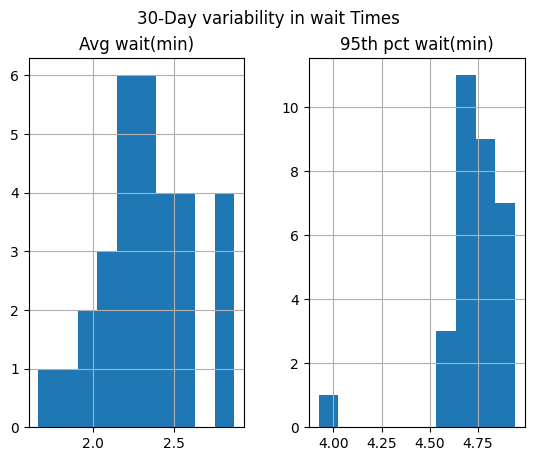

In [13]:
days=31
daily=[]
for _ in range(days):
  w,_=simulate_with_abandon(opt[0])
  daily.append((w.mean()*60,np.percentile(w*60,95)))
df=pd.DataFrame(daily,columns=['Avg wait(min)','95th pct wait(min)'])
print(df)
df.hist(bins=10)
plt.suptitle('30-Day variability in wait Times')
plt.show()

In [14]:
df.describe()

,Avg wait(min),95th pct wait(min)
count,31.000000,31.000000
mean,2.334935,4.730726
std,0.291844,0.172632
min,1.660560,3.924112
25%,2.201918,4.707016
50%,2.337149,4.740586
75%,2.505757,4.823496
max,2.873523,4.940171


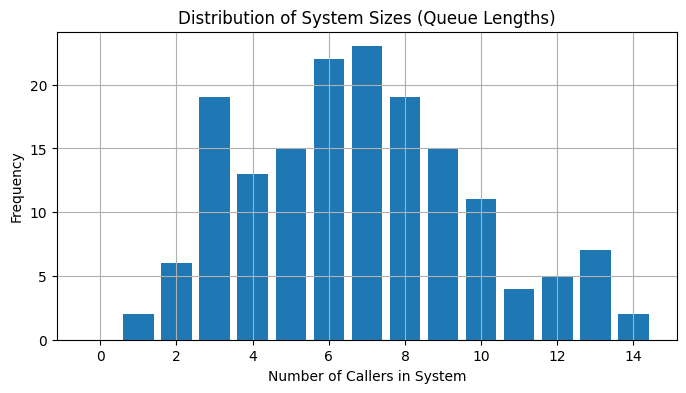

In [15]:
# Plot the distribution of system sizes (queue lengths)
plt.figure(figsize=(8, 4))
plt.hist(system_sizes, bins=range(int(system_sizes.max()) + 2), align='left', rwidth=0.8)
plt.title("Distribution of System Sizes (Queue Lengths)")
plt.xlabel("Number of Callers in System")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

#Conclusion
This project explored the simulation of a call center environment to identify the ideal number of agents required to manage customer interactions effectively during an 8-hour workday. By applying an M/M/s queueing framework, we modeled key performance metrics such as arrival patterns, service durations, system congestion, and customer wait times.

Our analysis covered several important aspects:

How varying the number of agents influences overall wait times

Handling fluctuating call volumes throughout the day, from low-traffic to peak periods

The impact of long waits on customer abandonment

Incorporating agent break schedules into staffing efficiency

Balancing operational costs with customer service quality

Understanding day-to-day performance variability through repeated simulations

#Final Recommendation:
Based on the simulation outcomes, deploying 5 agents emerged as the most effective staffing choice. This configuration meets the target of keeping the majority of wait times under 5 minutes, controls abandonment to acceptable levels, and strikes a balance between cost-efficiency and service quality—delivering a reliable and optimized call center operation.

